<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q) 

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

AR: indica que a variável é regressada em seus valores

I: indica que os valores de dados foram substituídos com a diferença entre os valores anteriores (diferenciação).

MA: Indica que o erro de regressão é uma combinação linear dos termos de erro dos valores passados.


p = ordem da autorregressão

d = grau da diferenciação

q = ordem da média móvel

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from time import time
from datetime import datetime
from datetime import date, timedelta

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Referência: Data Science Academy" --iversions

Author: Referência: Data Science Academy

numpy      : 1.21.5
pandas     : 1.4.4
sys        : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
matplotlib : 3.5.2
scipy      : 1.9.1
sklearn    : 1.0.2
statsmodels: 0.13.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-10-26 to 2022-10-25
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Quantidade  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [5]:
# Dados
dataframe.head()

Quantidade
Data                  
2021-10-26       162.0
2021-10-27        66.0
2021-10-28        58.0
2021-10-29        44.0
2021-10-30        83.0

In [6]:
type(dataframe.index)

pandas.core.indexes.datetimes.DatetimeIndex

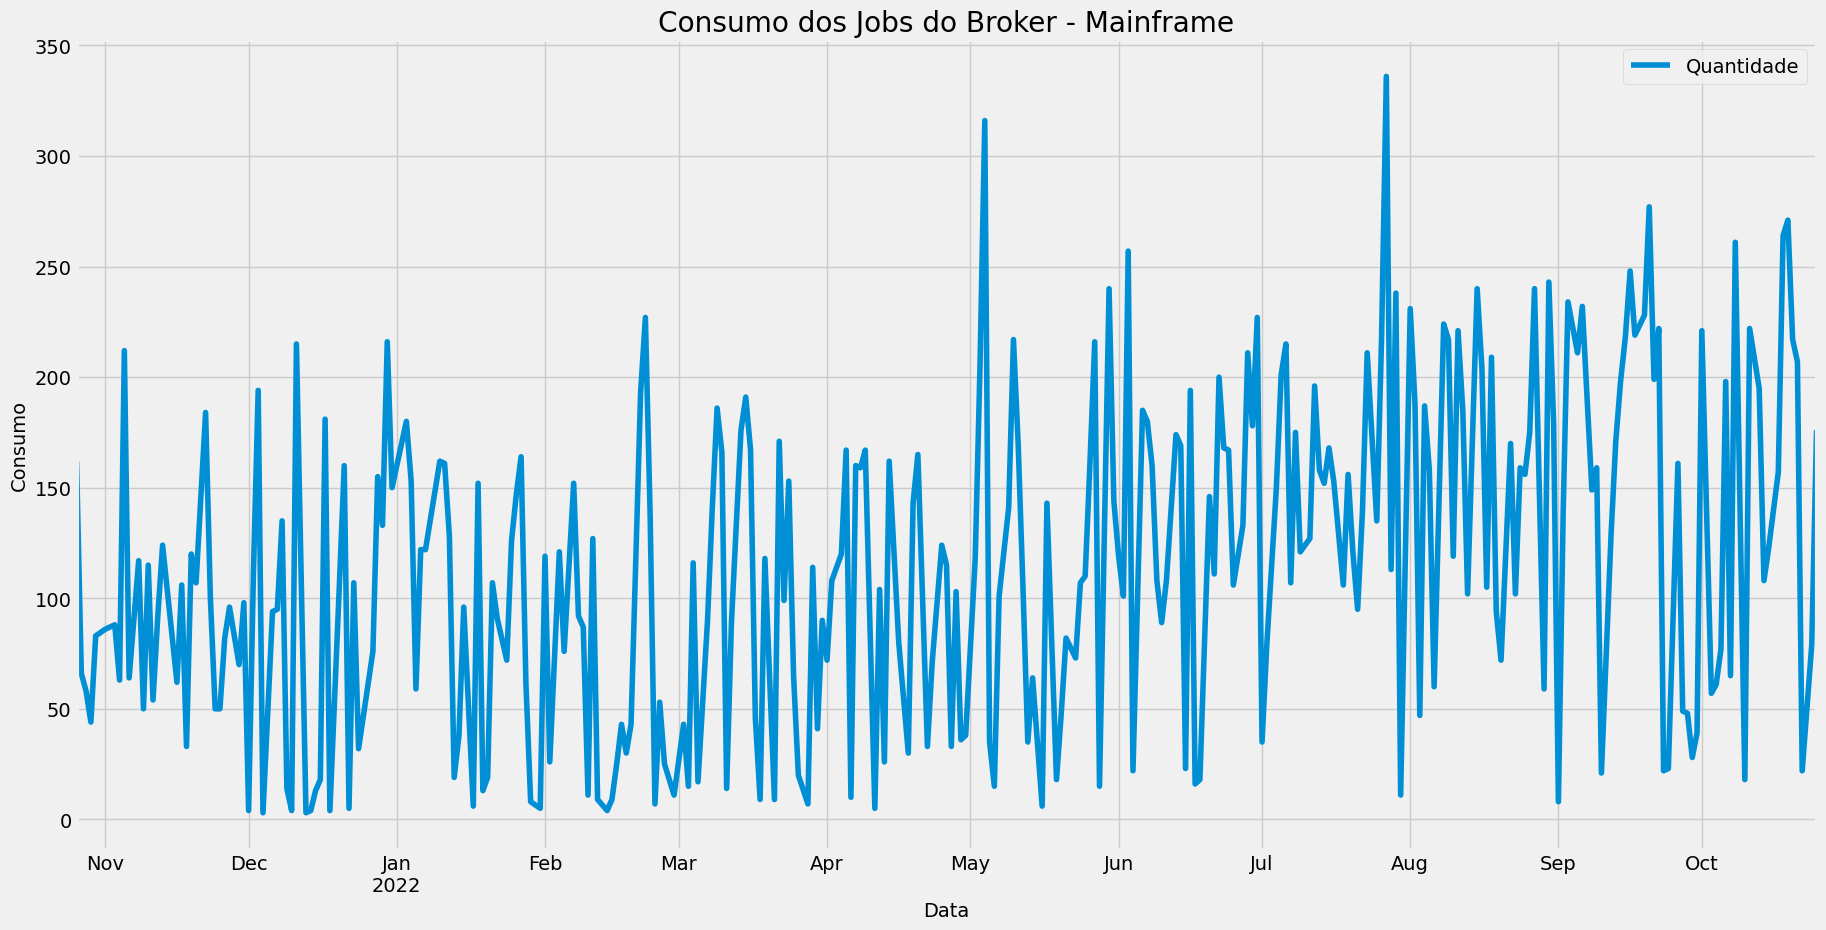

In [7]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# teste de performance para ver qual é o melhor número de lags para a média móvel

optimal_n = None

best_mse = None

db = dataframe[['Quantidade']].values.astype('float32')

mean_results_for_all_possible_n_values = np.zeros(int(len(db) / 2 - 2))


for n in range(3, int(len(db) / 2 + 1)):
    mean_for_n = np.zeros(len(db) - n)
    for i in range(0, len(db) - n):
        mean_for_n[i] = np.power(np.mean(db[:, 0][i:i+n]) - db[i + n][0], 2)
    mean_results_for_all_possible_n_values[n - 3] = np.mean(mean_for_n)
optimal_n = np.argmin(mean_results_for_all_possible_n_values) + 3
best_mse = np.min(mean_results_for_all_possible_n_values)


print("MSE = %s" % mean_results_for_all_possible_n_values)
print("Melhor MSE = %s" % best_mse)
print("Otimo n = %s" % optimal_n)

MSE = [5068.04799499 4917.44948391 4832.57116489 4680.66743919 4601.28609977
 4656.47249714 4648.29208504 4618.1796099  4610.80606949 4592.53503777
 4544.56260067 4493.46466427 4485.48570937 4456.10474853 4446.54376082
 4490.91705222 4492.9429392  4481.10310106 4490.61891631 4483.9428028
 4480.45540893 4501.98034094 4517.54216914 4493.07714509 4468.41292426
 4444.40871792 4417.65565054 4399.14375945 4406.86223299 4417.85519878
 4432.78520515 4448.76752622 4439.62652808 4445.48228711 4450.15094925
 4489.72363942 4484.82035394 4480.19878219 4470.50696831 4461.04938591
 4456.78035303 4485.19356336 4500.957051   4490.03759362 4460.83989726
 4482.27877274 4460.98055348 4445.99417169 4441.08734272 4441.02776
 4434.54324841 4431.02284913 4428.68004725 4423.55408763 4411.85474958
 4413.71459437 4441.95717404 4461.40524106 4480.51457958 4492.94108679
 4496.3396505  4499.50019551 4508.18889129 4465.68045695 4474.41203163
 4485.88777018 4486.56346476 4474.20414417 4466.48086736 4475.56797586
 449

In [9]:
# Média móvel de 30 dias - (ótimo n = 30 anterior)

rolmean = dataframe.rolling(window = 30).mean()

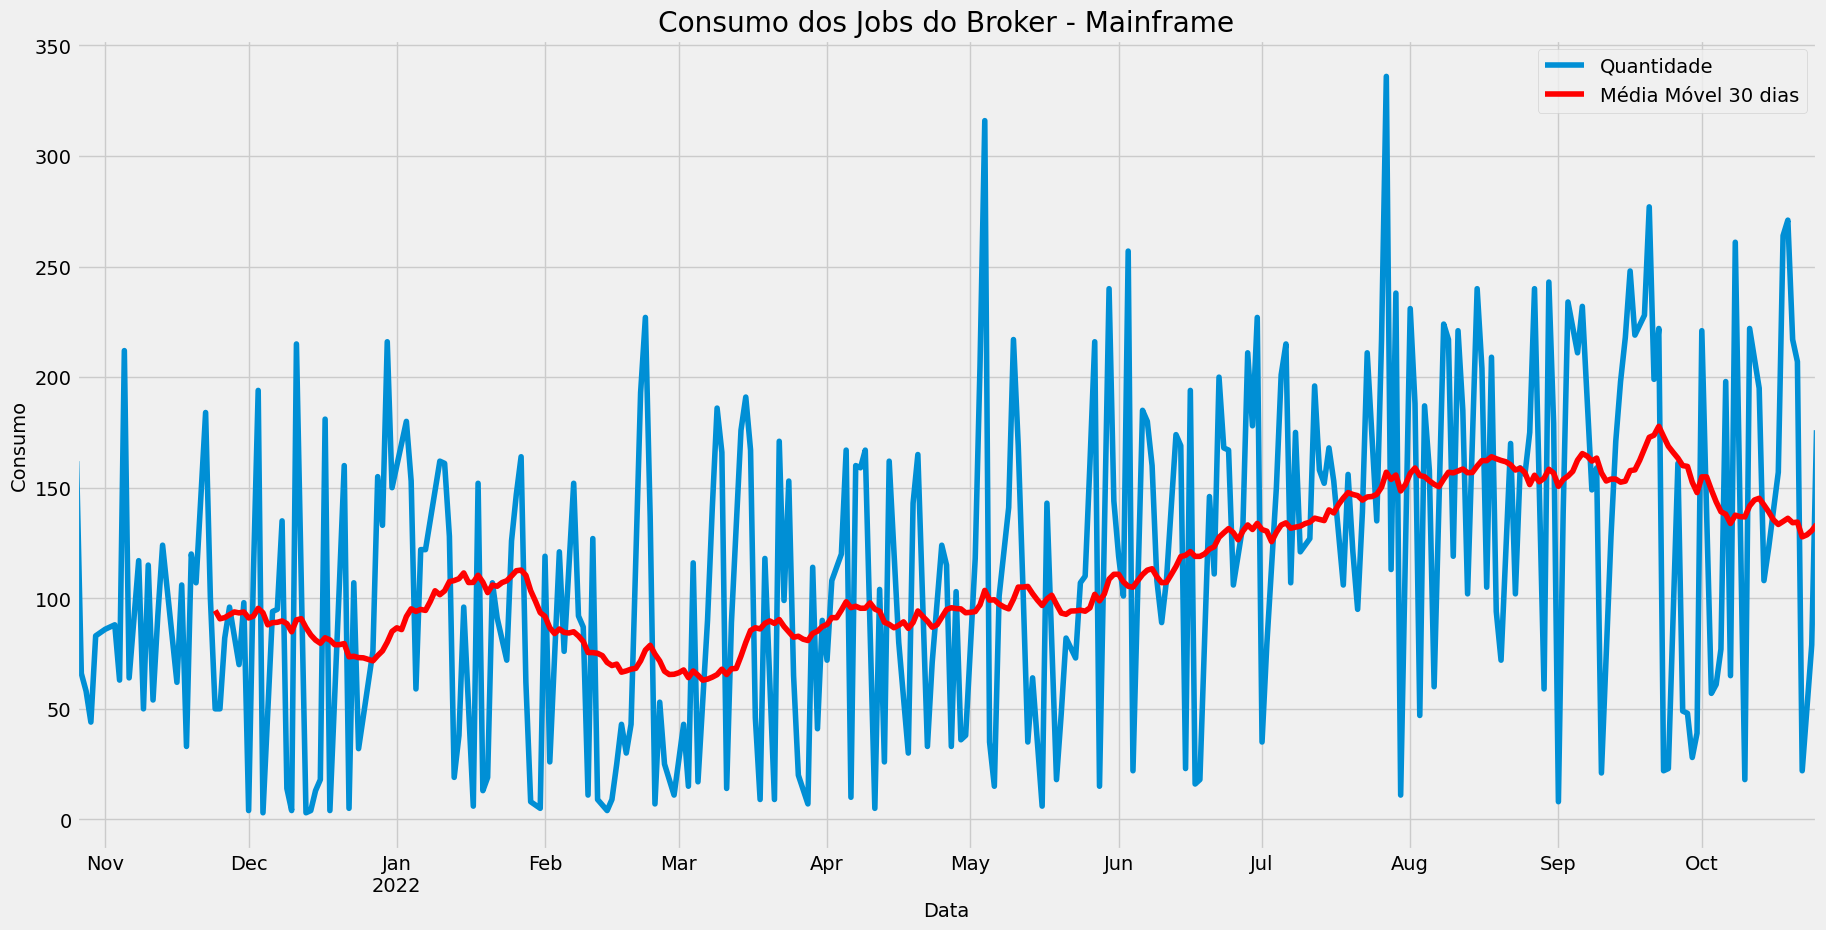

In [10]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.plot(rolmean, label = 'Média Móvel 30 dias', color = 'red')
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [11]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Quantidade']

p: ordem da parte autoregressiva - PACF

d: grau de diferenciação - Teste de Estacionariedade

q: ordem da média móvel - ACF

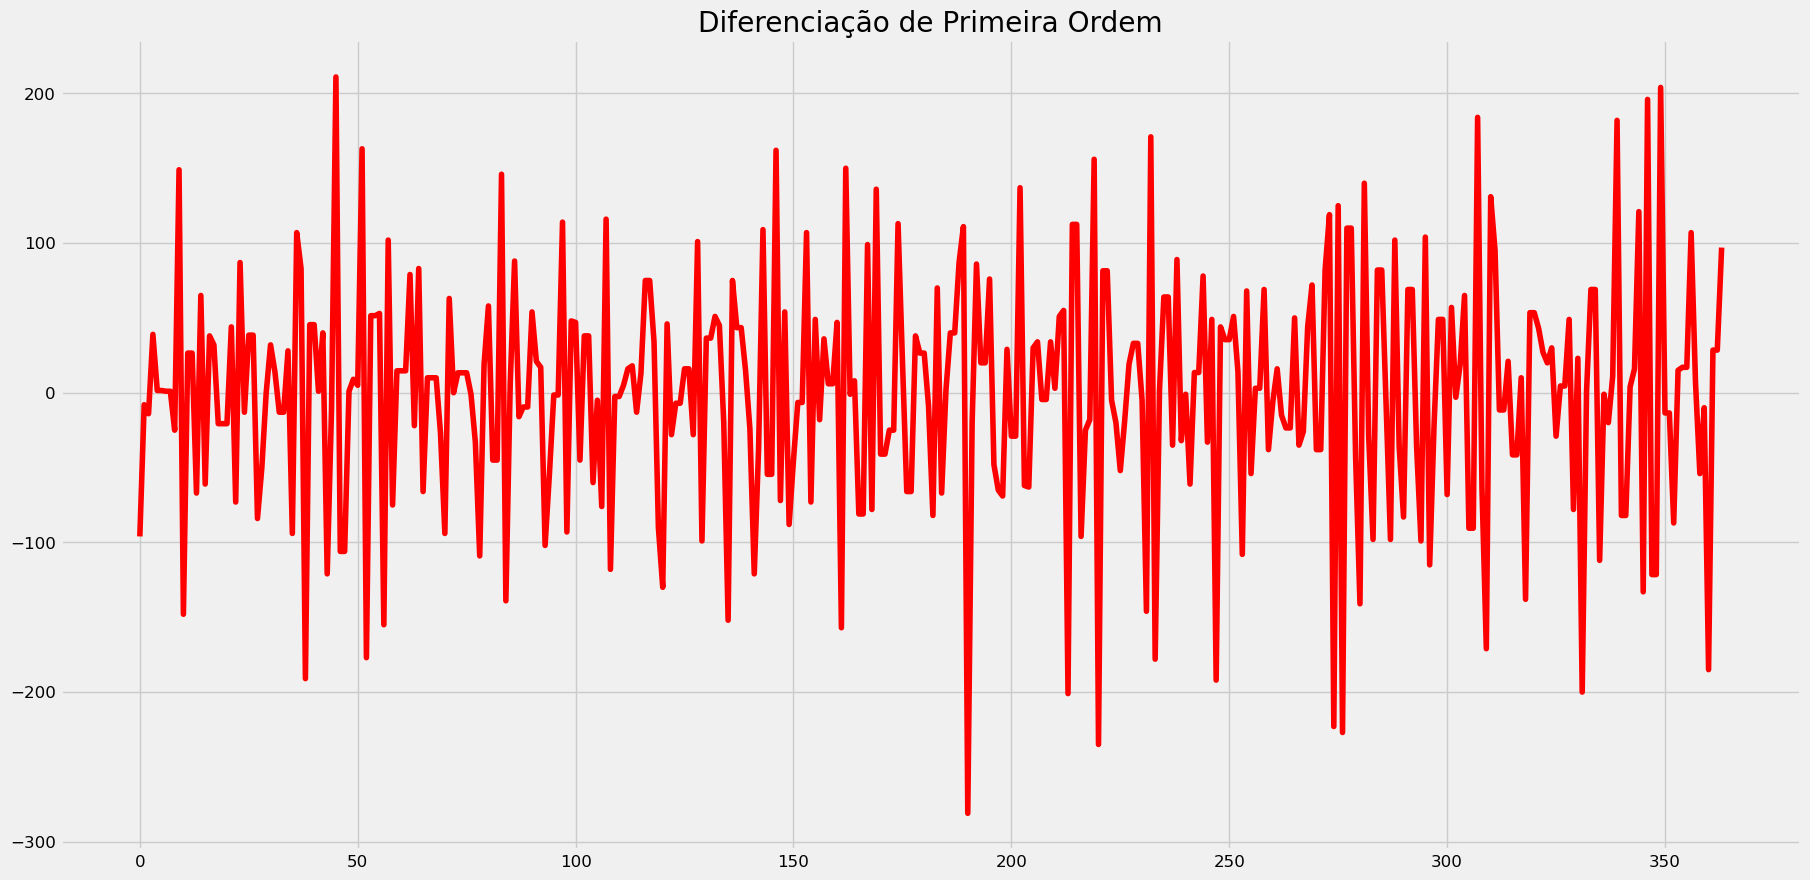

In [12]:
# Gráfico PACF
plt.plot(np.diff(target.values), color = 'red'); 
plt.title('Diferenciação de Primeira Ordem')
plt.show()

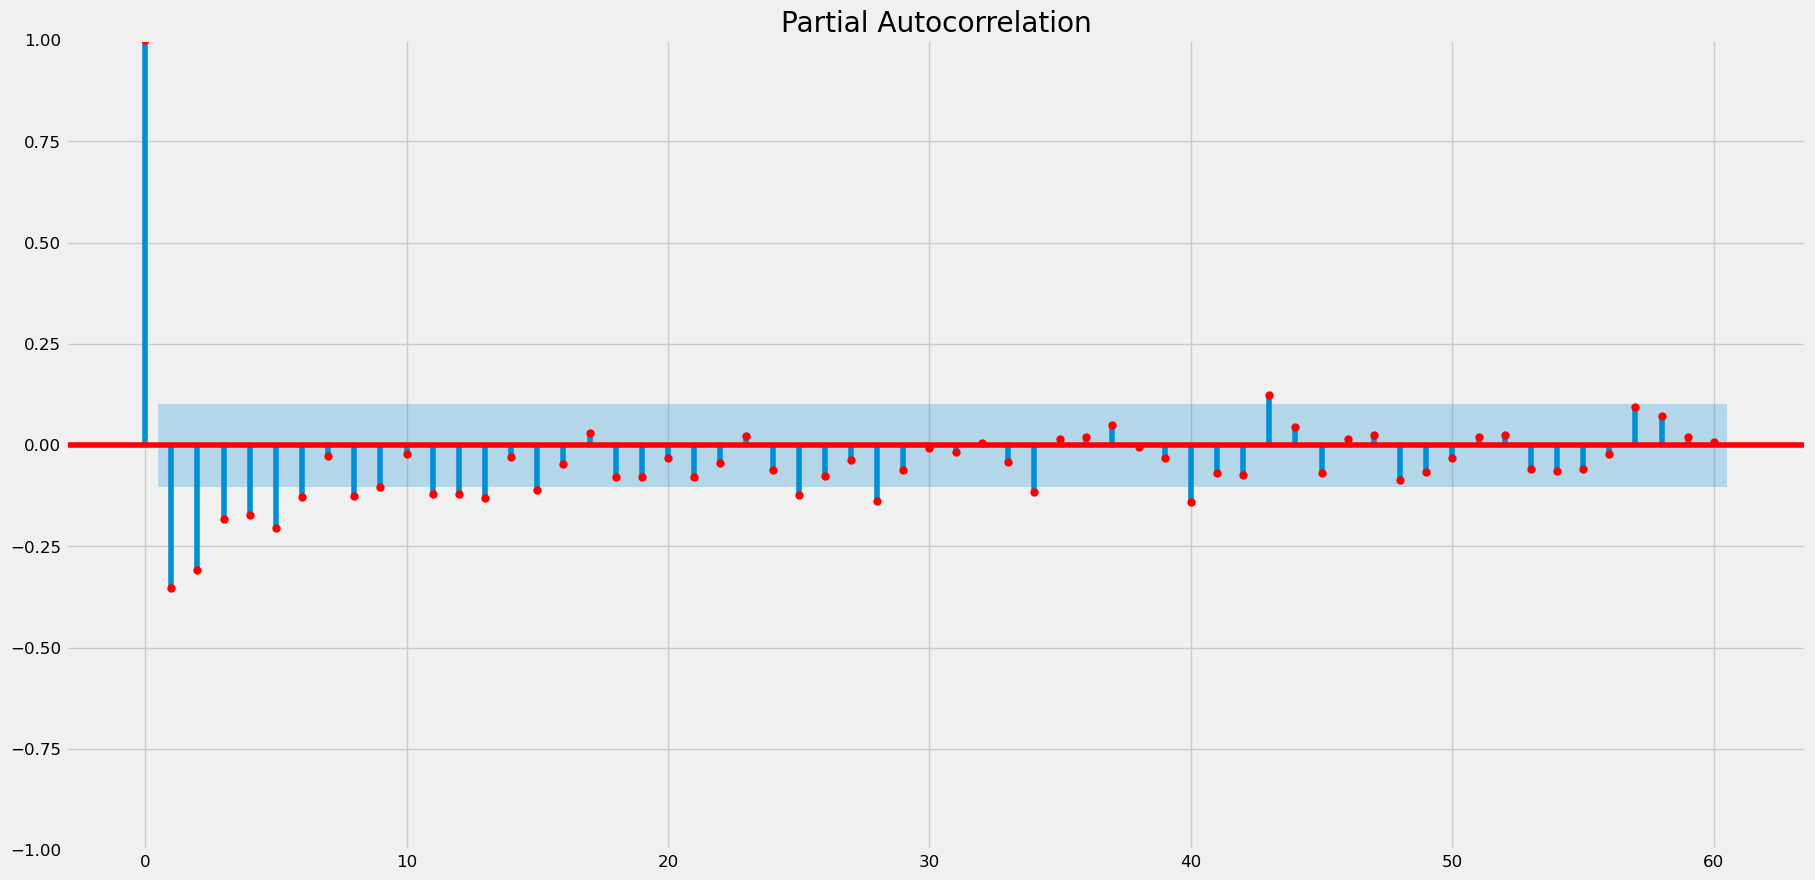

In [13]:
# Gráfico PACF
plot_pacf(np.diff(target.values), lags = 60, color = 'red')
plt.show()

In [14]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

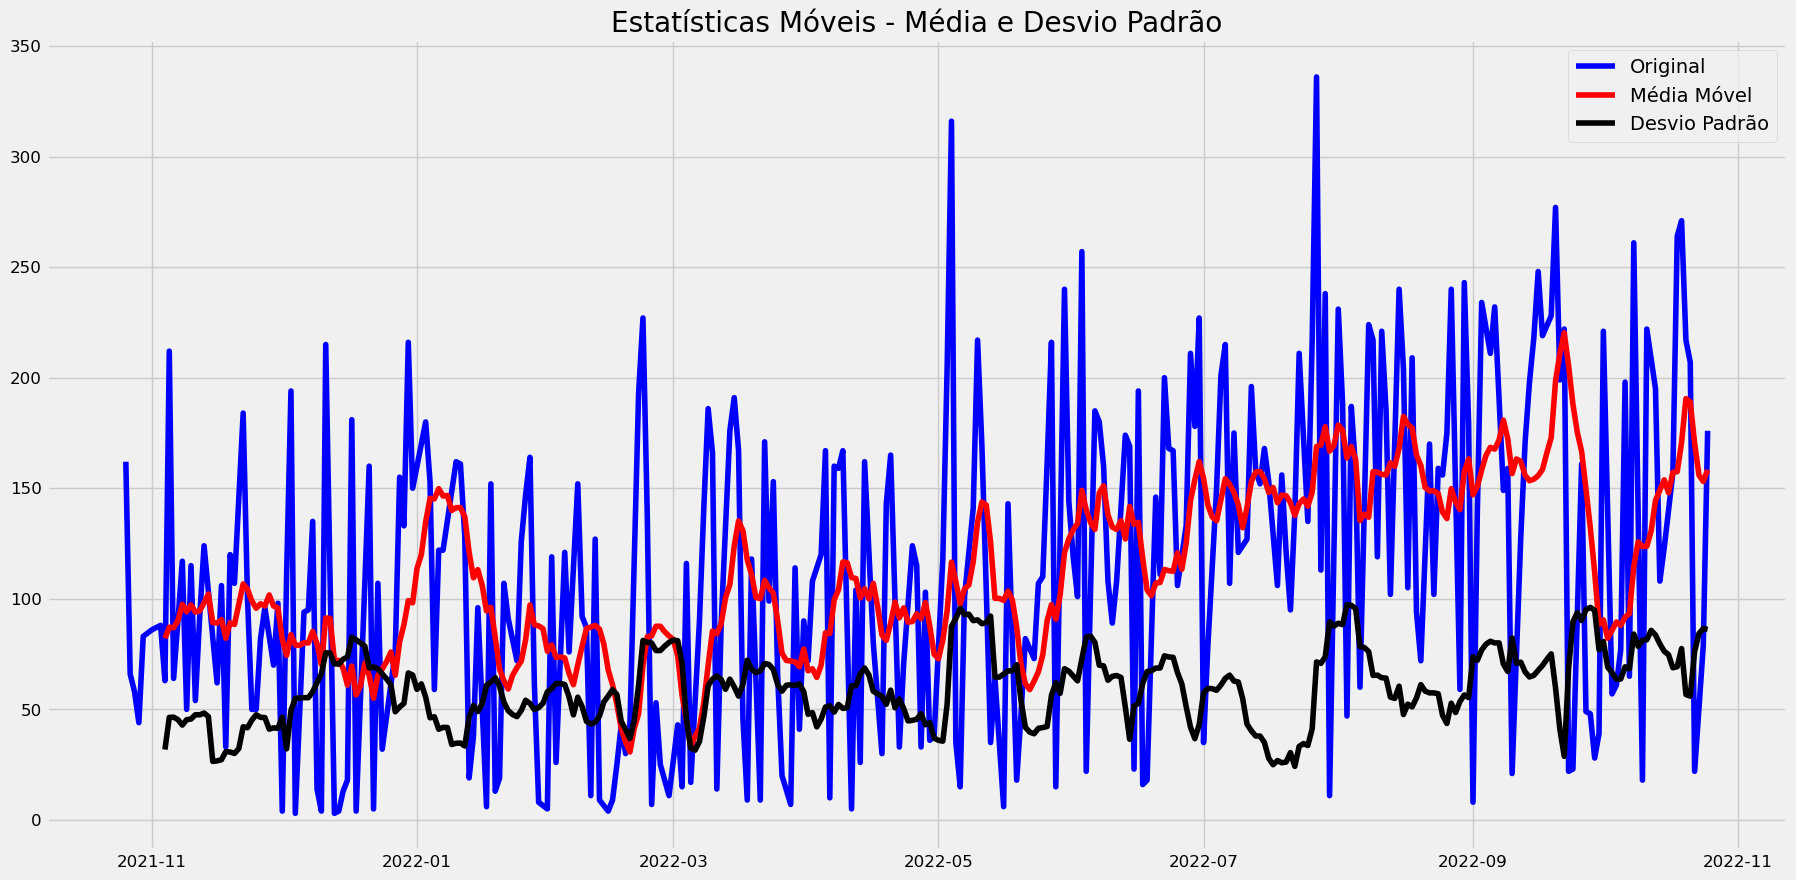


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -5.155394
Valor-p                           0.000011
Número de Lags Consideradas       5.000000
Número de Observações Usadas    359.000000
Valor Crítico (1%)               -3.448697
Valor Crítico (5%)               -2.869625
Valor Crítico (10%)              -2.571077
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [15]:
# Aplica a função 
testa_estacionaridade(dataframe['Quantidade'])

In [16]:
# Teste ADF
resultado = adfuller(target)
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: -5.155394
Valor-p: 0.000011


O valor-p é menor que 0.05, portanto, não precisamos calcular o valor de 'd' pelo Modelo ARIMA.

A a série temporal é estacionária.

In [17]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [18]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

Ou seja, o Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

Vamos escolher d = 1 pois vimos no gráfico a diferença quando aplicamos a primeira diferenciação. 

d = 1

ARIMA (p, d, q) = (0, 1, q)

q: ordem da média móvel - ACF

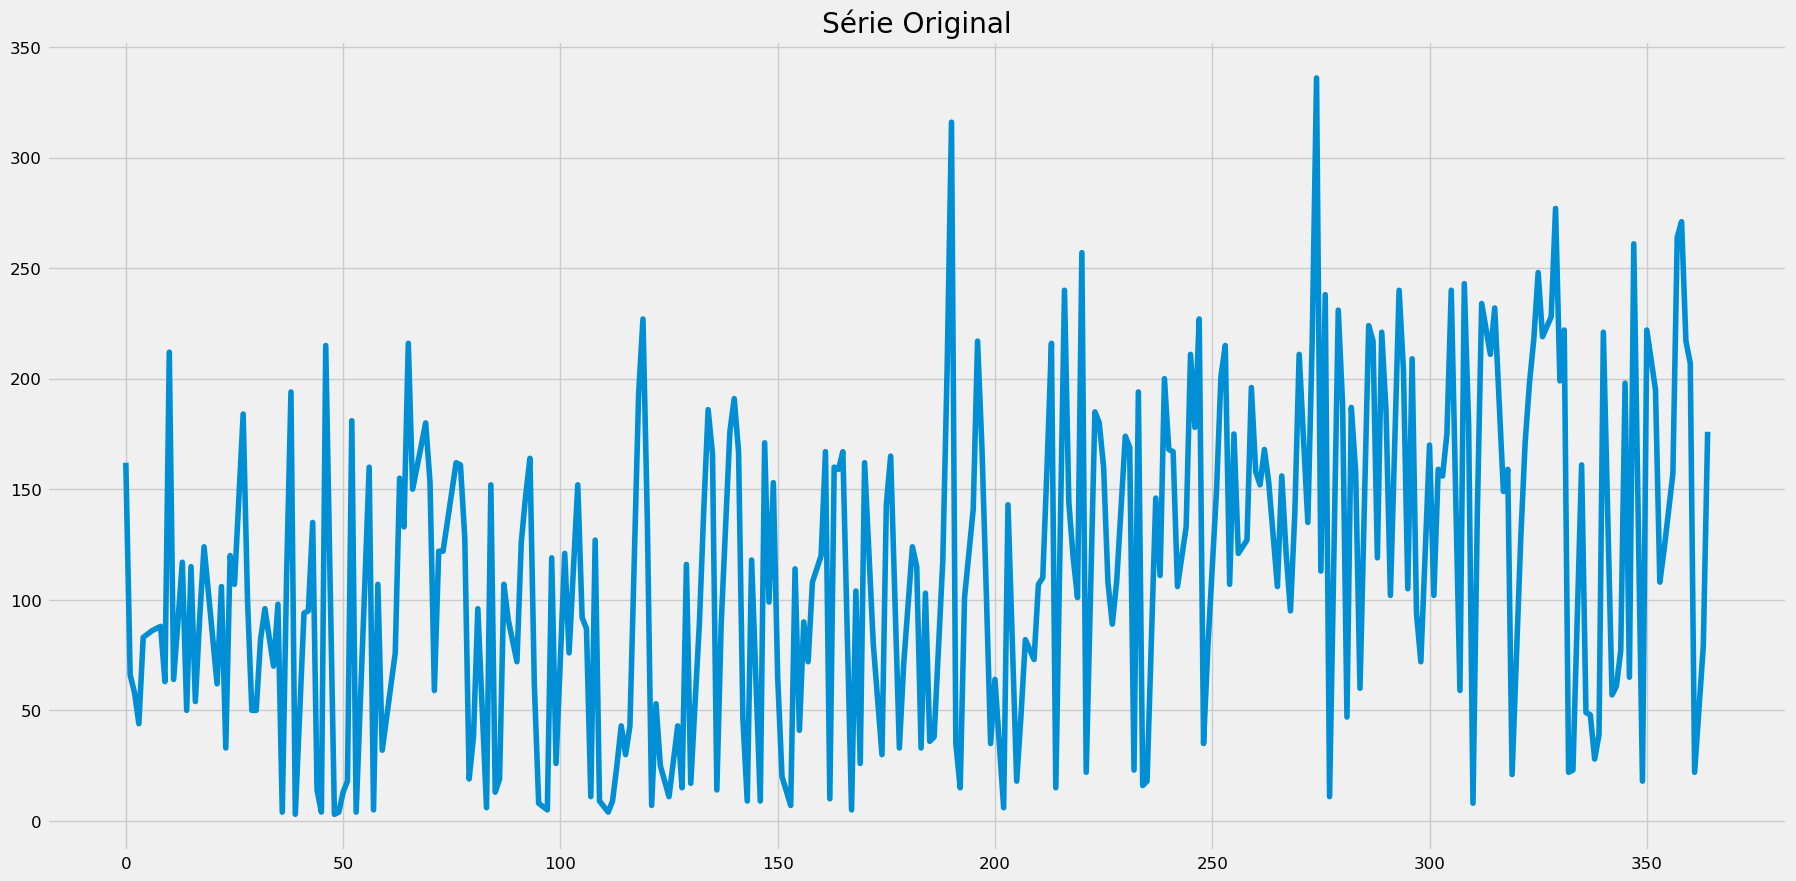

In [19]:
# Gráfico ACF
plt.plot(target.values)
plt.title('Série Original')
plt.show()

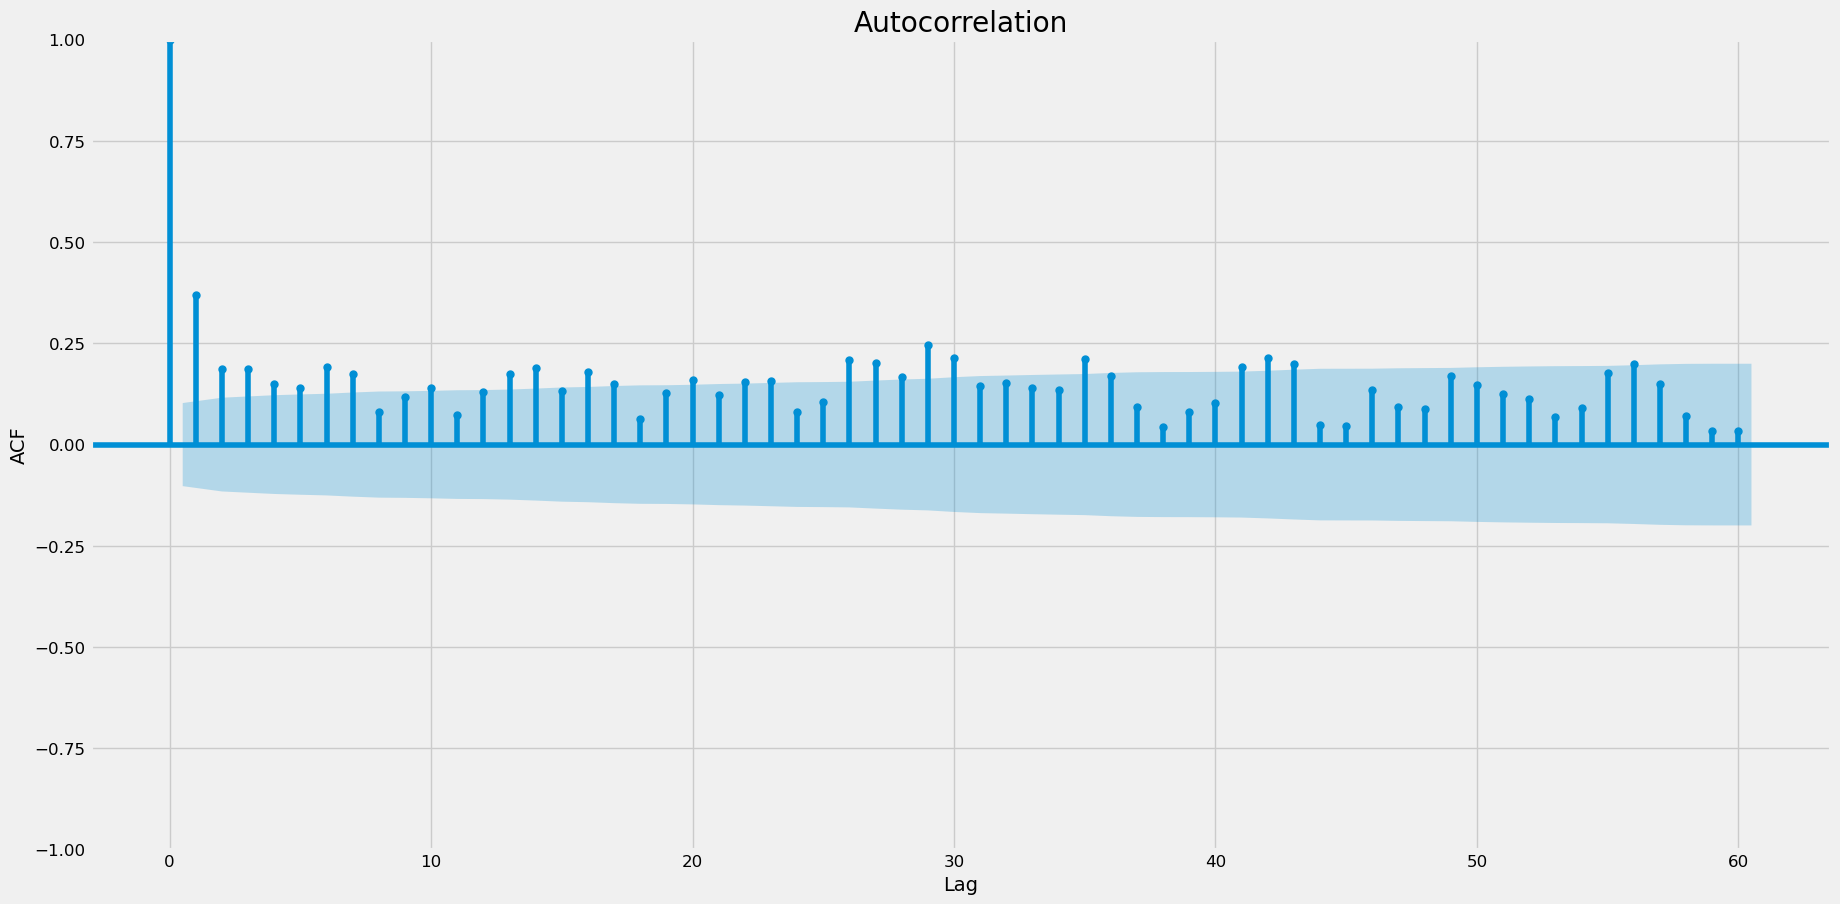

In [20]:
plot_acf(target,lags=60)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

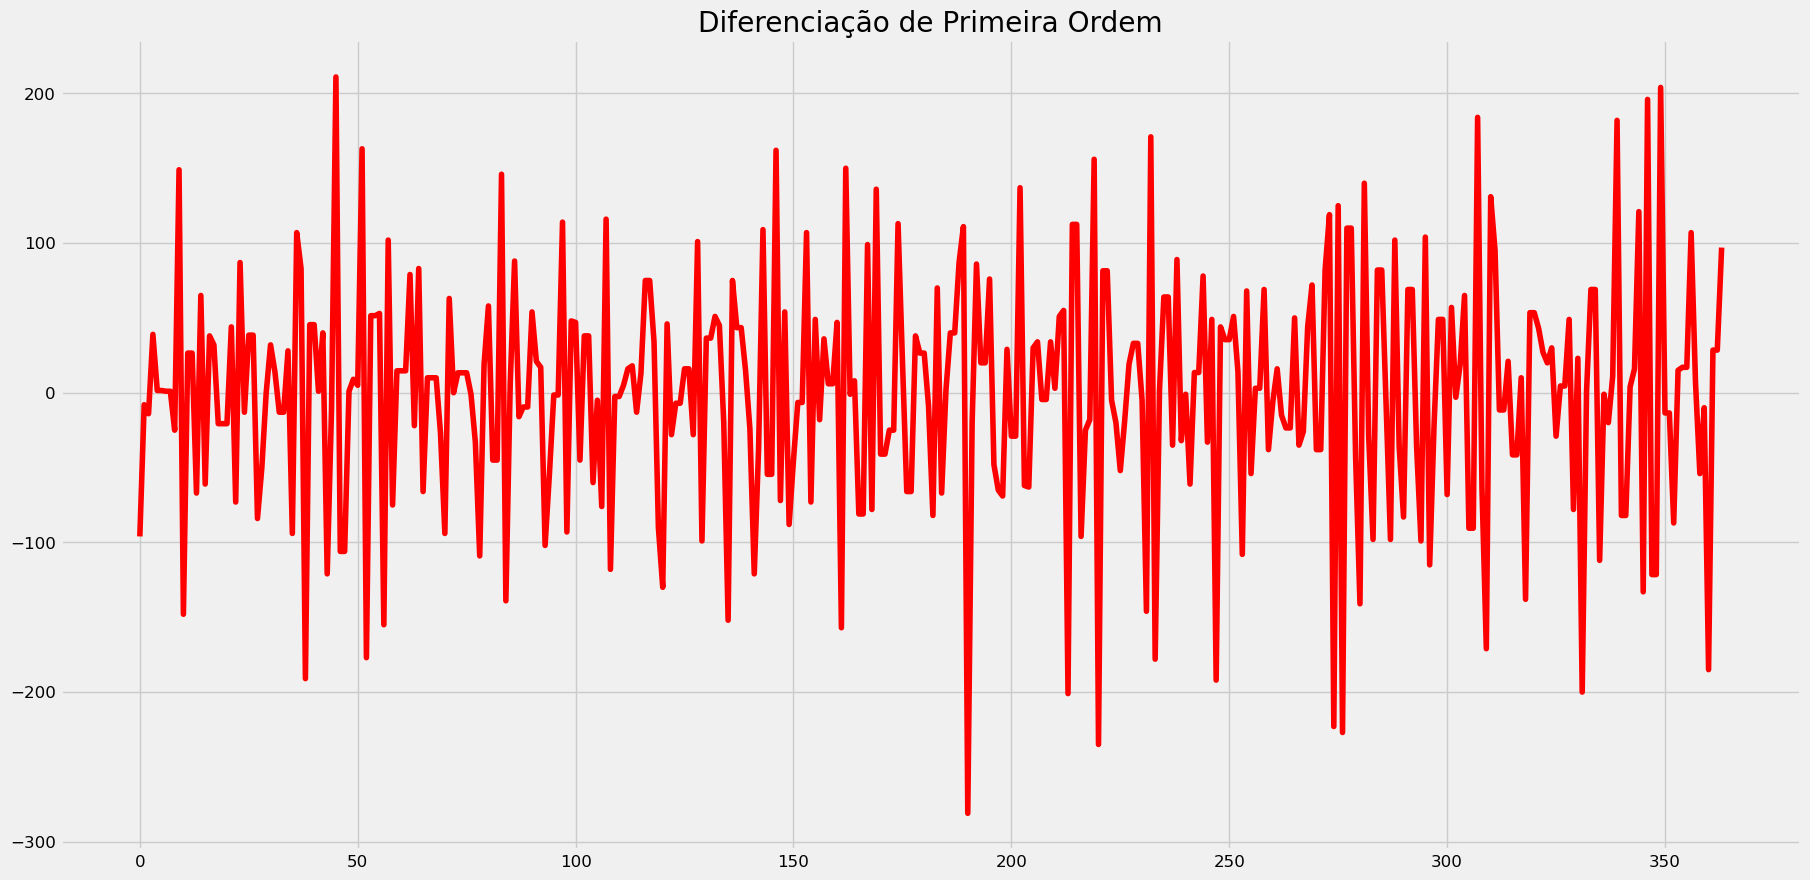

In [21]:
# Gráfico ACF
plt.plot(np.diff(target.values), color = 'red')
plt.title('Diferenciação de Primeira Ordem')
plt.show()

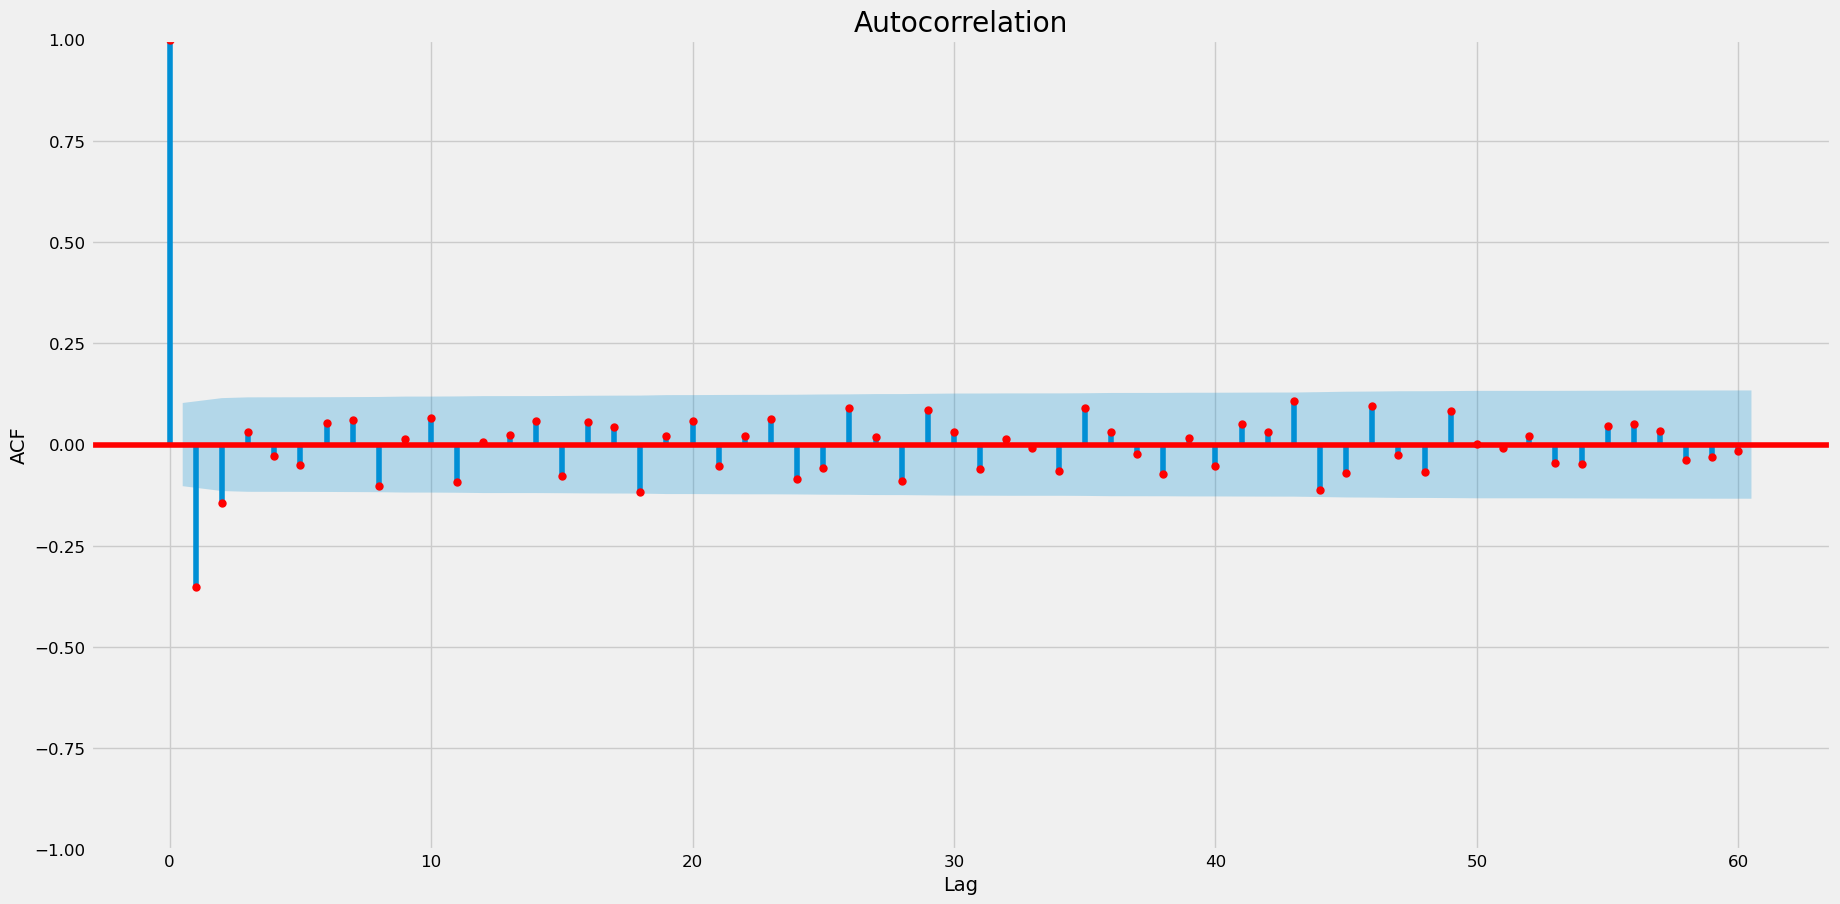

In [22]:
plot_acf(np.diff(target.values),lags=60, color = 'red')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

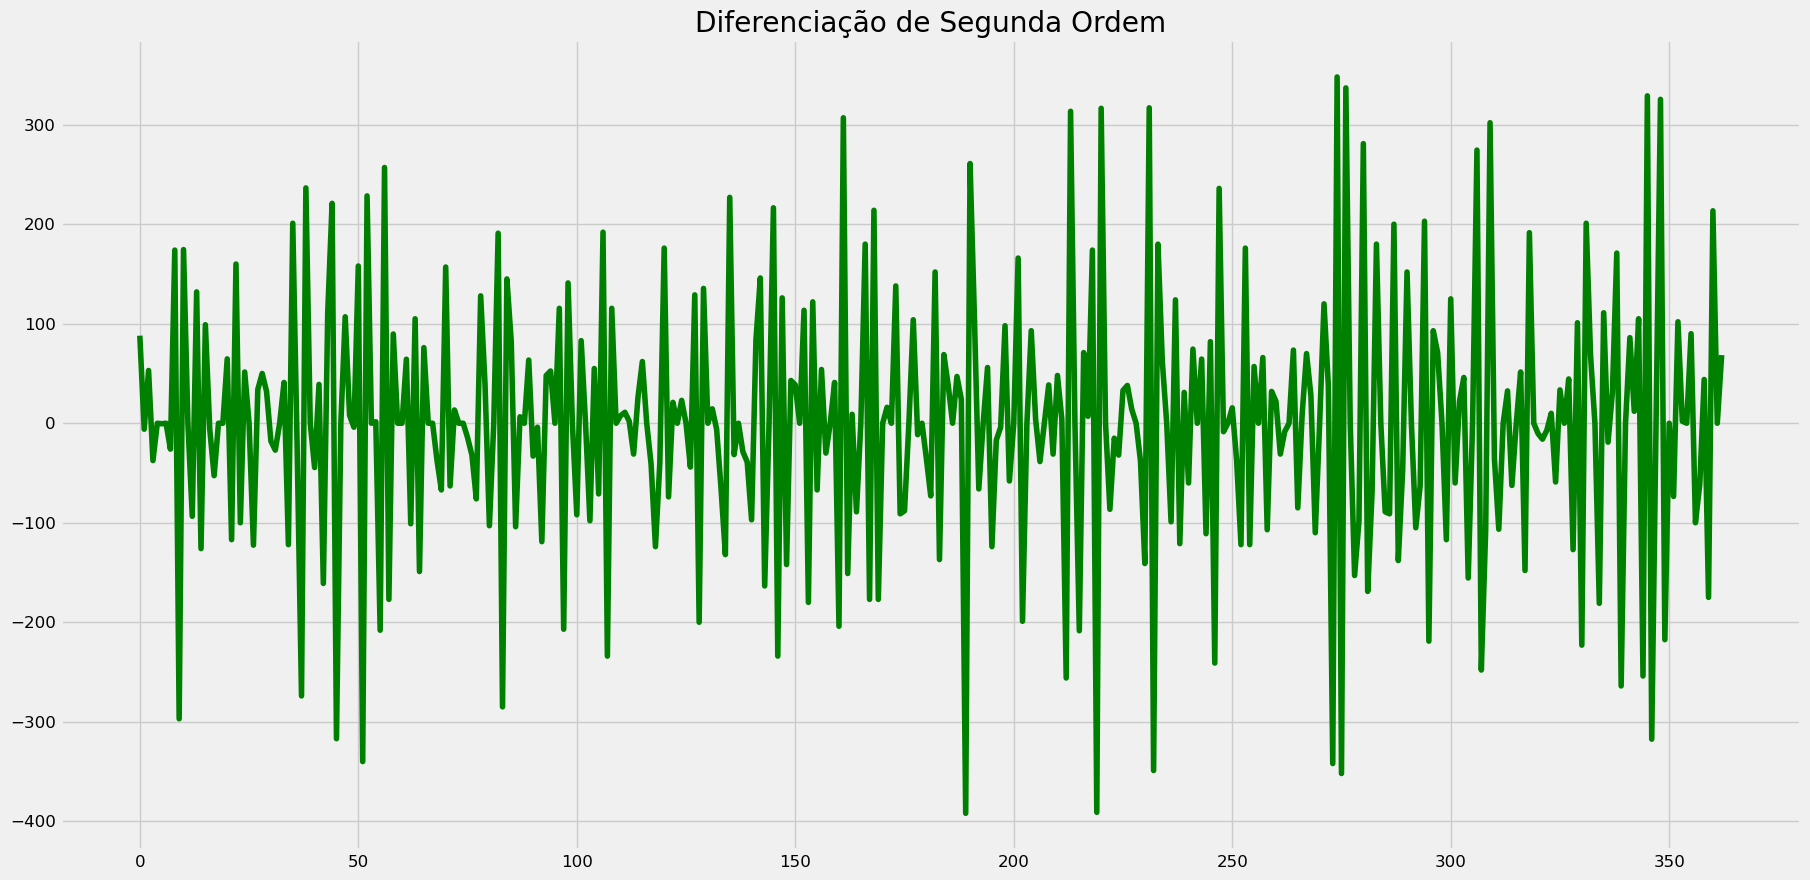

In [23]:
# Gráfico ACF
plt.plot(np.diff(np.diff(target.values)), color = 'green') 
plt.title('Diferenciação de Segunda Ordem')
plt.show()

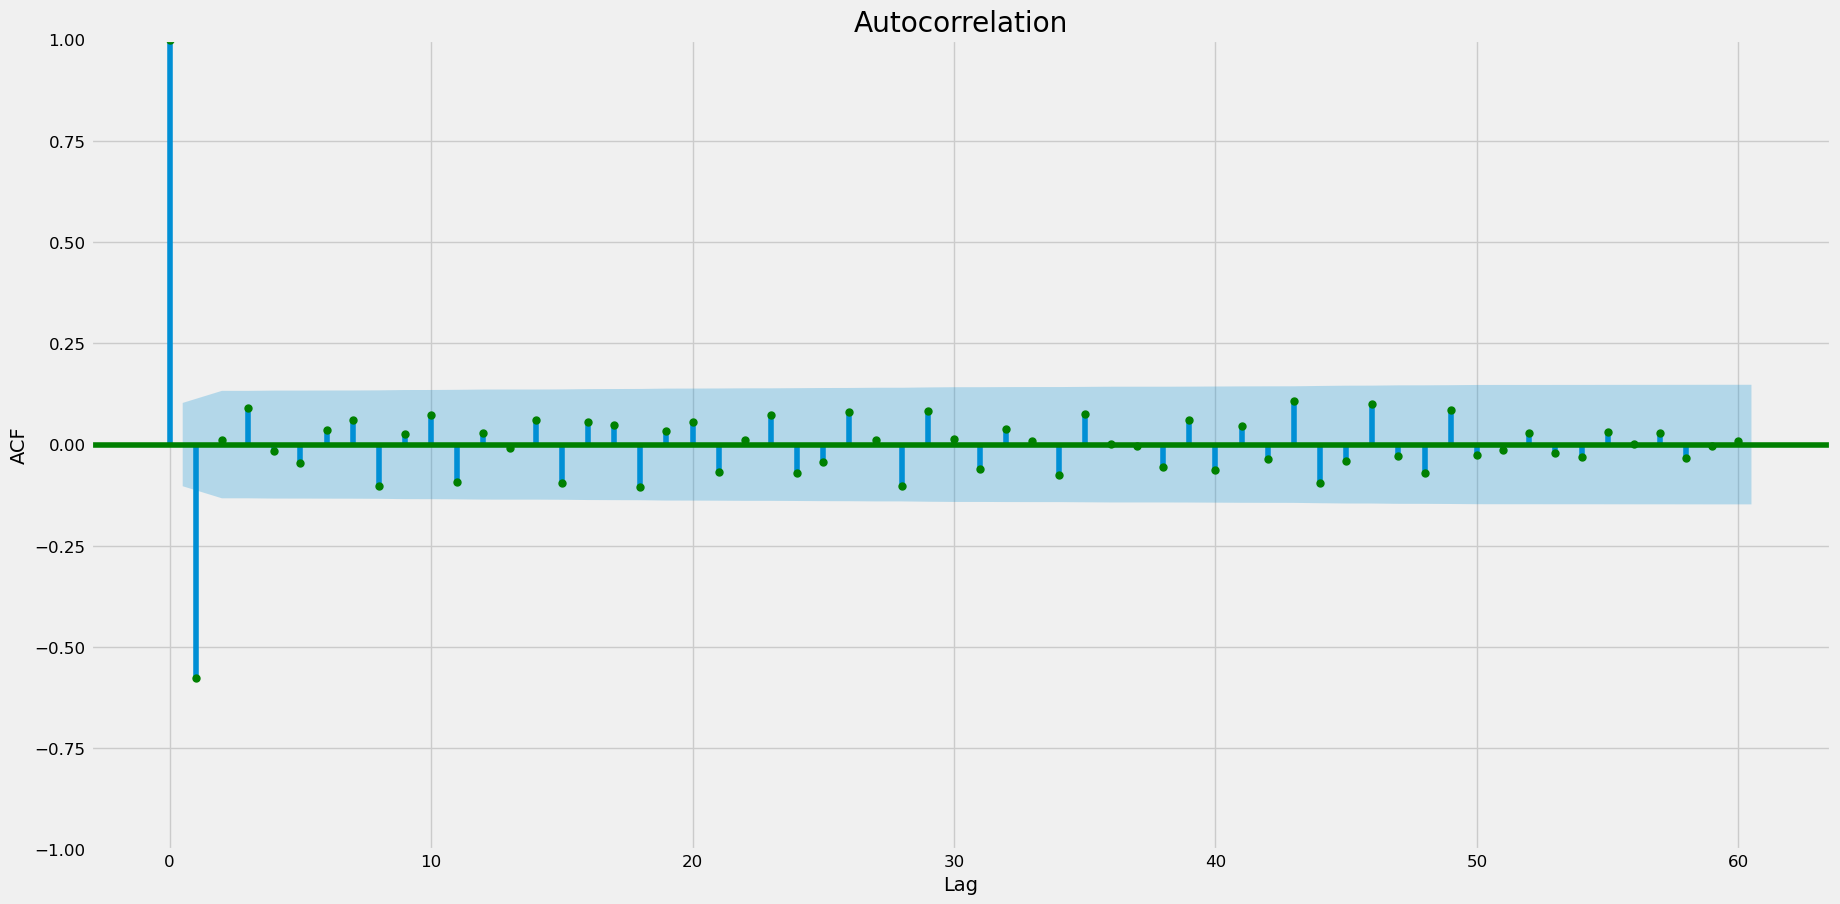

In [24]:
plot_acf(np.diff(np.diff(target.values)),lags=60, color = 'green')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

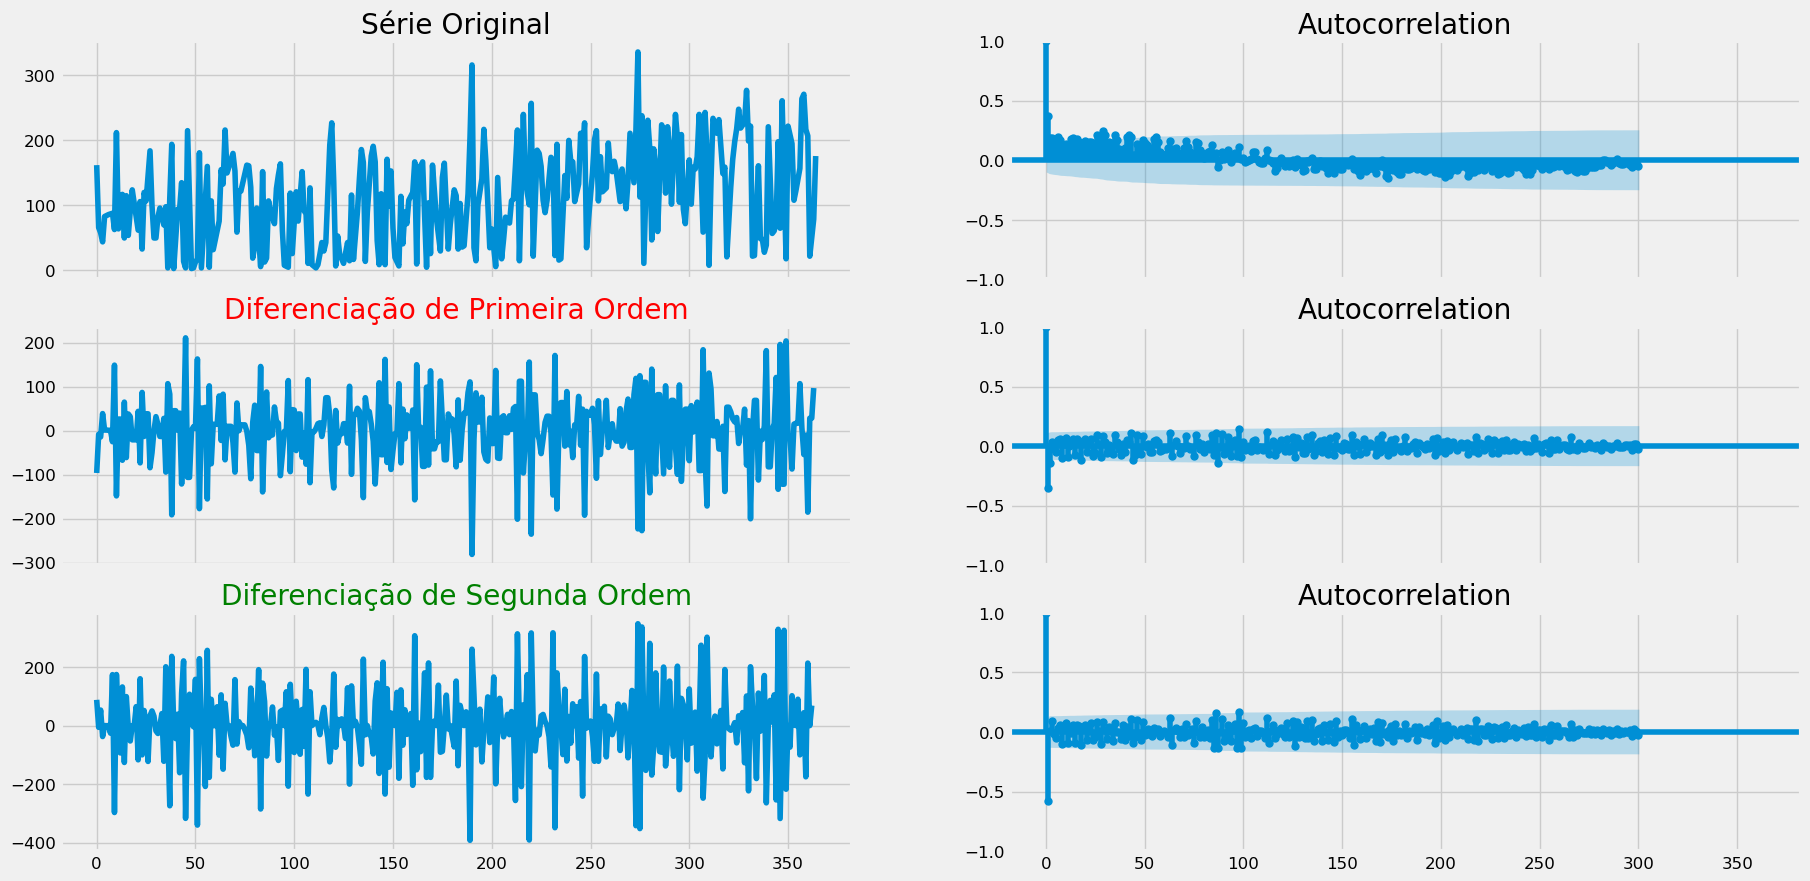

In [25]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 300, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem', color = 'RED')
plot_acf(np.diff(target.values), lags = 300, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem', color = 'green')
plot_acf(np.diff(np.diff(target.values)), lags = 300, ax = axes[2, 1])

plt.show()

q = 1

ARIMA (p, d, q) = (0, 1, 1)

In [26]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dataframe['Quantidade'])

In [27]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

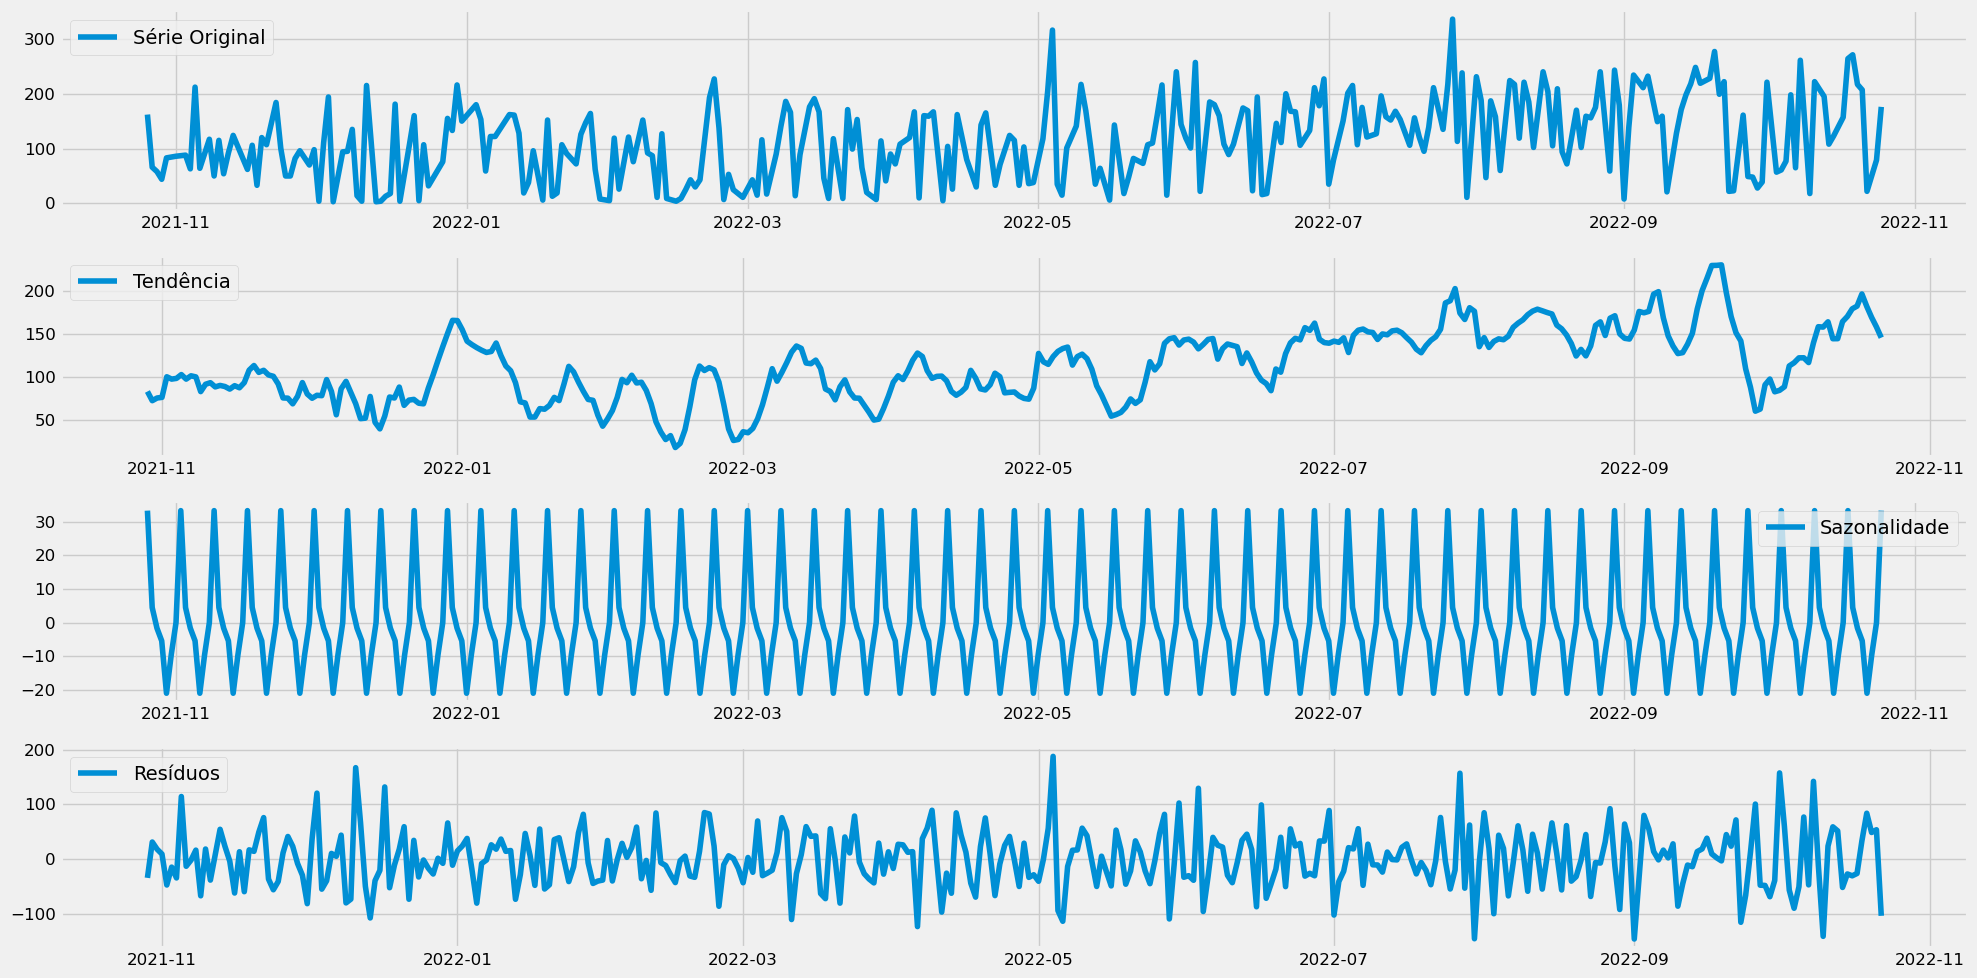

In [28]:
# Plot
plt.subplot(411)
plt.plot(dataframe['Quantidade'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

In [29]:
# Random seed 
np.random.seed(7)

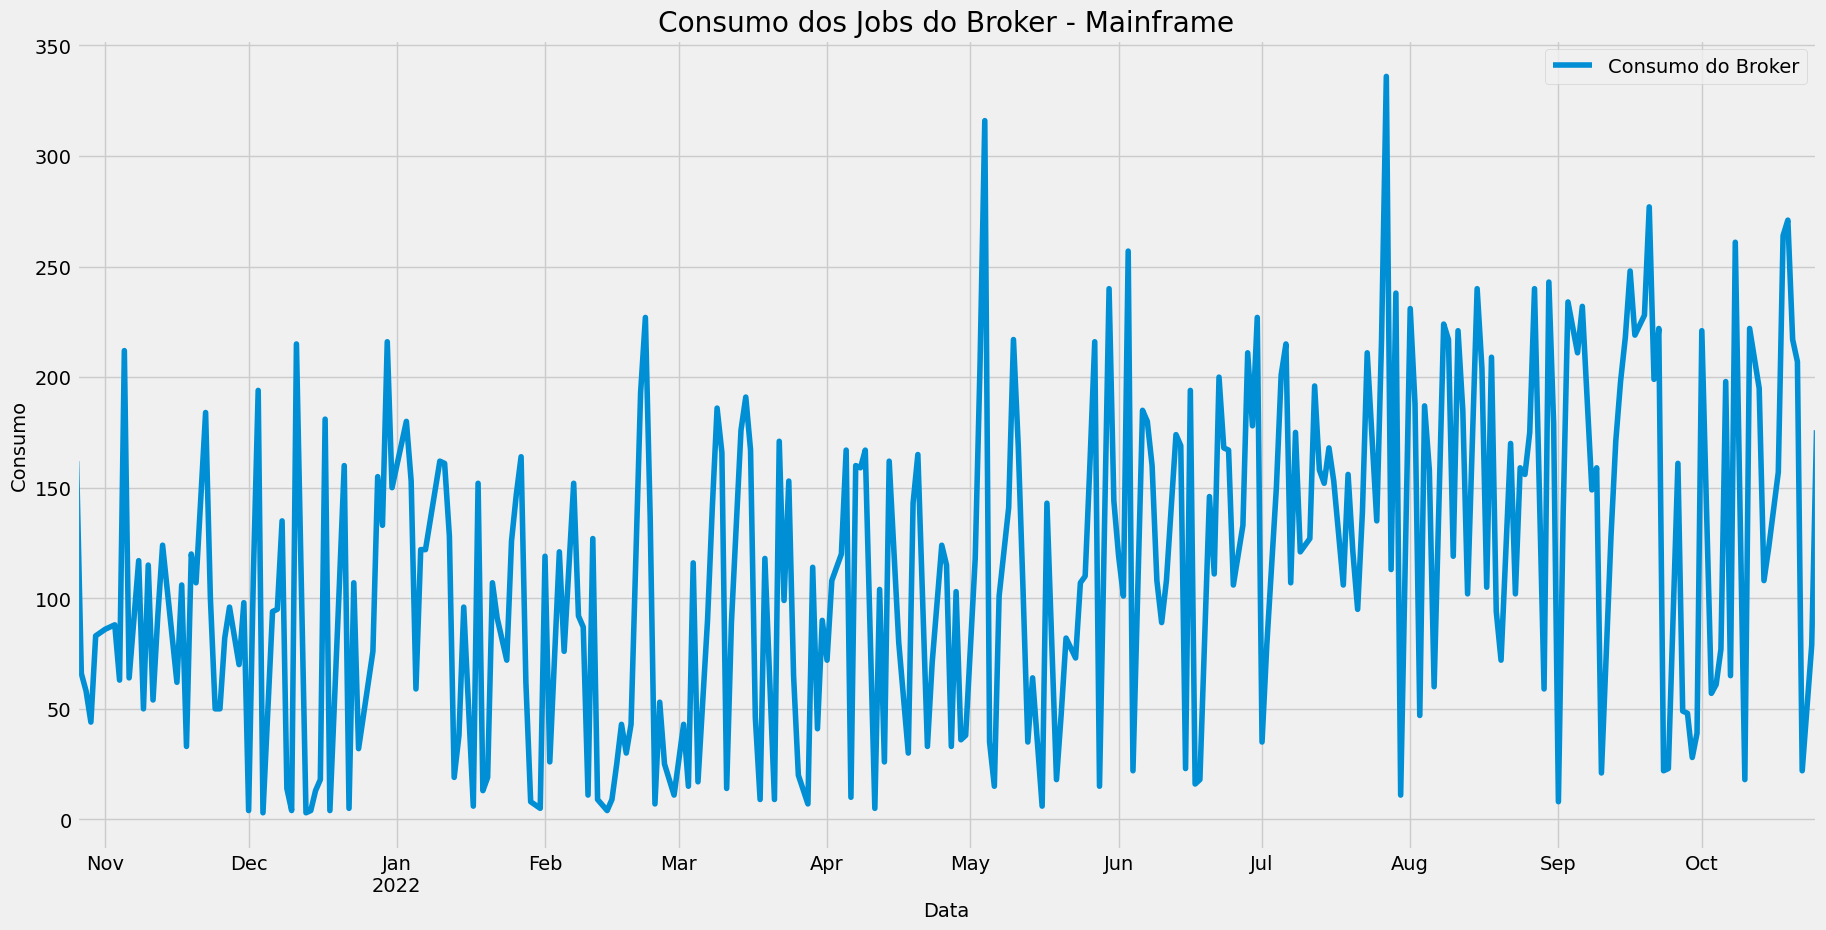

In [30]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [31]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

273 92


In [32]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [33]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [34]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [35]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

A escolha é sua meu caro(a) Cientista de Dados.

In [36]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [37]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        #model = ARIMA(history, order = arima_order)
        #model = statsmodels.tsa.arima.model.ARIMA(history, order = arima_order)        
        #model = ARIMA(history, order = arima_order)
        model = sm.tsa.arima.ARIMA(history, order = arima_order)
        #model_fit = model.fit(method = 'mle', disp = 0)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
      
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [38]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s   MSE = %.4f   RMSE = %.4f'% (order, mse, np.sqrt(mse)))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s   MSE = %.4f   RMSE = %.4f' % (best_cfg, best_score, np.sqrt(best_score)))

In [41]:
# Valores para o grid
p_values = [1]
d_values = [1] 
q_values = [1] 

In [39]:
# Valores para o grid
p_values = [0, 1, 2, 3, 4, 5]
d_values = [0, 1] 
q_values = [0, 1, 2, 3, 4, 5] 

In [40]:
# Testando o melhor valor de p, d e q nos dados de treino

start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

warnings.simplefilter("ignore")

avalia_melhor_arima(treino.values, p_values, d_values, q_values)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 20:30:27
ARIMA(0, 0, 0)   MSE = 4596.5804   RMSE = 67.7981
ARIMA(0, 0, 1)   MSE = 4121.3086   RMSE = 64.1974
ARIMA(0, 0, 2)   MSE = 4066.0556   RMSE = 63.7656
ARIMA(0, 0, 3)   MSE = 4028.3973   RMSE = 63.4697
ARIMA(0, 0, 4)   MSE = 4155.9015   RMSE = 64.4663
ARIMA(0, 0, 5)   MSE = 4171.8857   RMSE = 64.5901
ARIMA(0, 1, 0)   MSE = 5671.3188   RMSE = 75.3082
ARIMA(0, 1, 1)   MSE = 3436.6609   RMSE = 58.6230
ARIMA(0, 1, 2)   MSE = 3549.4778   RMSE = 59.5775
ARIMA(0, 1, 3)   MSE = 3577.5606   RMSE = 59.8127
ARIMA(0, 1, 4)   MSE = 3658.7188   RMSE = 60.4873
ARIMA(0, 1, 5)   MSE = 3746.8373   RMSE = 61.2114
ARIMA(1, 0, 0)   MSE = 3985.2658   RMSE = 63.1290
ARIMA(1, 0, 1)   MSE = 4013.0431   RMSE = 63.3486
ARIMA(1, 0, 2)   MSE = 3756.2481   RMSE = 61.2882
ARIMA(1, 0, 3)   MSE = 3800.5672   RMSE = 61.6487
ARIMA(1, 0, 4)   MSE = 3889.4468   RMSE = 62.3654
ARIMA(1, 0, 5)   MSE = 3878.9263   RMSE = 62.2810
ARIMA(1, 1, 0)   MSE = 4688.0406   RMSE = 68.4693
ARIMA(1, 1, 1)   MSE = 3

As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (0, 1, 1). 

## Vamos fazer previsões com o modelo usando 'ARIMA'

In [85]:
# Cria o modelo com os dados de treino
#modelo_arima = sm.tsa.arima.ARIMA(treino, order = (1, 1, 0))
#modelo_arima =  sm.tsa.arima.ARIMA(treino, order = (0, 1, 1))
#modelo_arima = ARIMA(treino, order = (6, 1, 1))
#modelo_arima = ARIMA(treino, order = (20, 1, 1))
#modelo_arima = ARIMA(treino, order = (15, 1, 1))
modelo_arima = sm.tsa.arima.ARIMA(treino, order = (15, 1, 7))

In [86]:
# Treina o modelo
#modelo_arima_fit = modelo_arima.fit(disp = -1)  
#modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)
modelo_arima_fit = modelo_arima.fit()

In [87]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Quantidade   No. Observations:                  273
Model:                ARIMA(15, 1, 7)   Log Likelihood               -1483.675
Date:                Wed, 21 Dec 2022   AIC                           3013.351
Time:                        21:34:20   BIC                           3096.284
Sample:                    10-26-2021   HQIC                          3046.646
                         - 07-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6869      0.385     -1.786      0.074      -1.441       0.067
ar.L2         -0.8501      0.233     -3.649      0.000      -1.307      -0.393
ar.L3         -0.5021      0.241     -2.080      0.038      -0.975      -0.029
ar.L4         -0.8413      0.255     -3.304      0.001      -1.340      -0.342
ar.L5         -0.6867      0.258     -2.663      0.008      -1.192      -0.181
ar.L6         -0.3512      0.308     -1.139      0.255      -0.955       0.253
ar.L7          0.1679      0.224      0.750      0.453      -0.271       0.607
ar.L8         -0.0217      0.194     -0.111      0.911      -0.403       0.359
ar.L9         -0.0122      0.184     -0.066      0.947      -0.372       0.348
ar.L10        -0.0114      0.193     -0.059      0.953      -0.390       0.368
ar.L11        -0.0474      0.171     -0.277      0.782      -0.383       0.288
ar.L12        -0.0984      0.148     -0.666      0.505      -0.388       0.191
ar.L13        -0.1552      0.133     -1.169      0.243      -0.415       0.105
ar.L14        -0.0057      0.118     -0.049      0.961      -0.236       0.225
ar.L15        -0.0634      0.097     -0.652      0.514      -0.254       0.127
ma.L1         -0.0341      0.383     -0.089      0.929      -0.785       0.716
ma.L2          0.1921      0.258      0.744      0.457      -0.314       0.698
ma.L3         -0.2706      0.203     -1.335      0.182      -0.668       0.127
ma.L4          0.2834      0.214      1.323      0.186      -0.136       0.703
ma.L5         -0.0394      0.227     -0.174      0.862      -0.484       0.405
ma.L6         -0.2913      0.226     -1.288      0.198      -0.735       0.152
ma.L7         -0.5821      0.317     -1.837      0.066      -1.203       0.039
sigma2      3325.2268    345.852      9.615      0.000    2647.369    4003.085
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.57
Prob(Q):                              0.97   Prob(JB):                         0.46
Heteroskedasticity (H):               1.08   Skew:                             0.18
Prob(H) (two-sided):                  0.73   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Previsão com o modelo treinado - Predict

In [88]:
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
print("inicio: ", inicio, " fim : ", fim, "n dias: ", td)

inicio:  2022-07-25 00:00:00  fim :  2022-10-25 00:00:00 n dias:  92 days, 0:00:00


In [89]:
# Previsões com o modelo
# Última data da série
fim = target.index[-1]
td = timedelta(len(teste))
inicio=fim - td
arima_predict = modelo_arima_fit.predict(start = inicio, end = fim, dynamic = False)

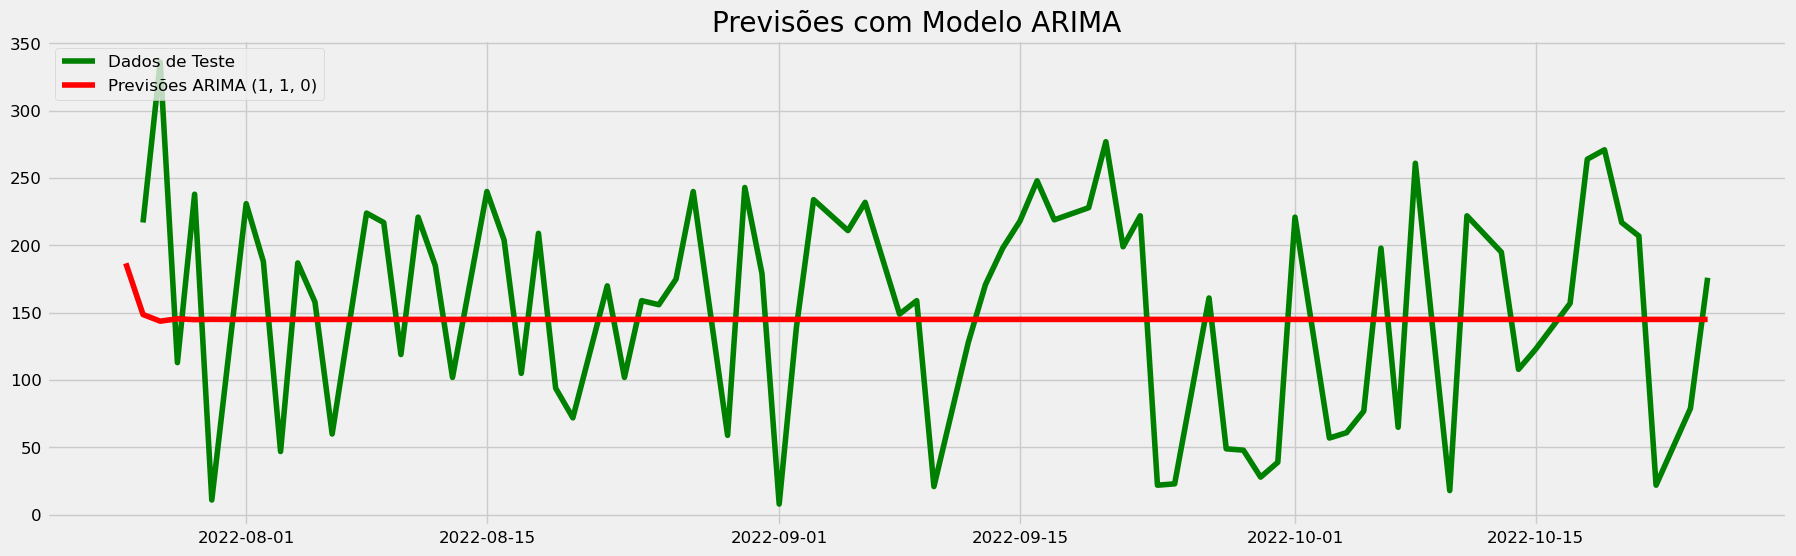

In [56]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (1, 1, 0)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

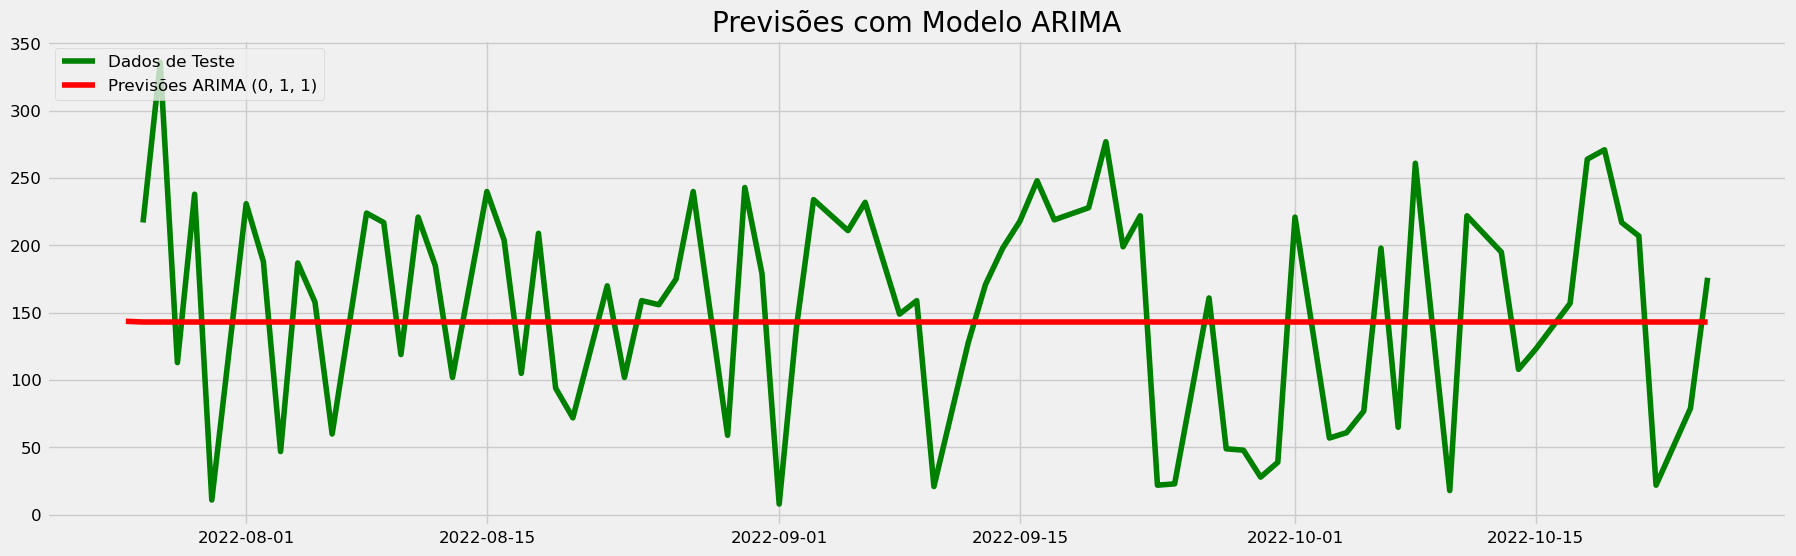

In [66]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (0, 1, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

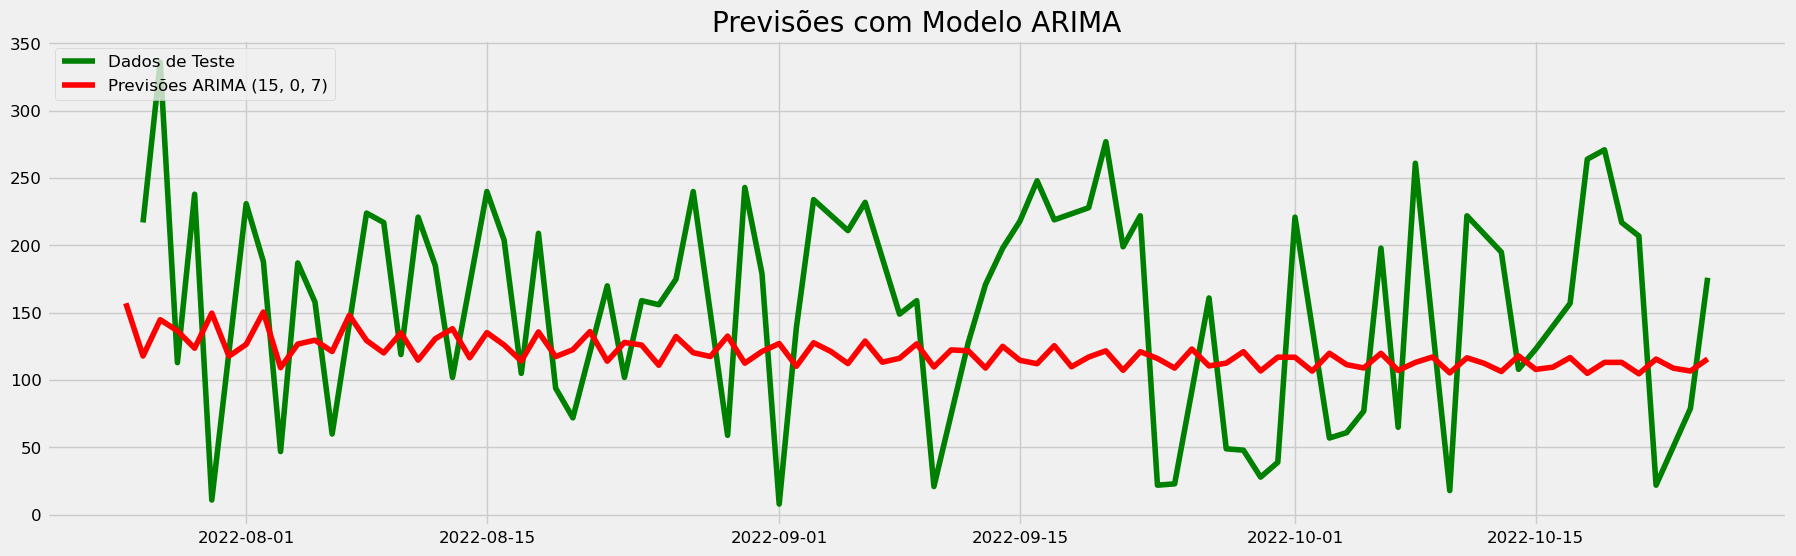

In [74]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 0, 7)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

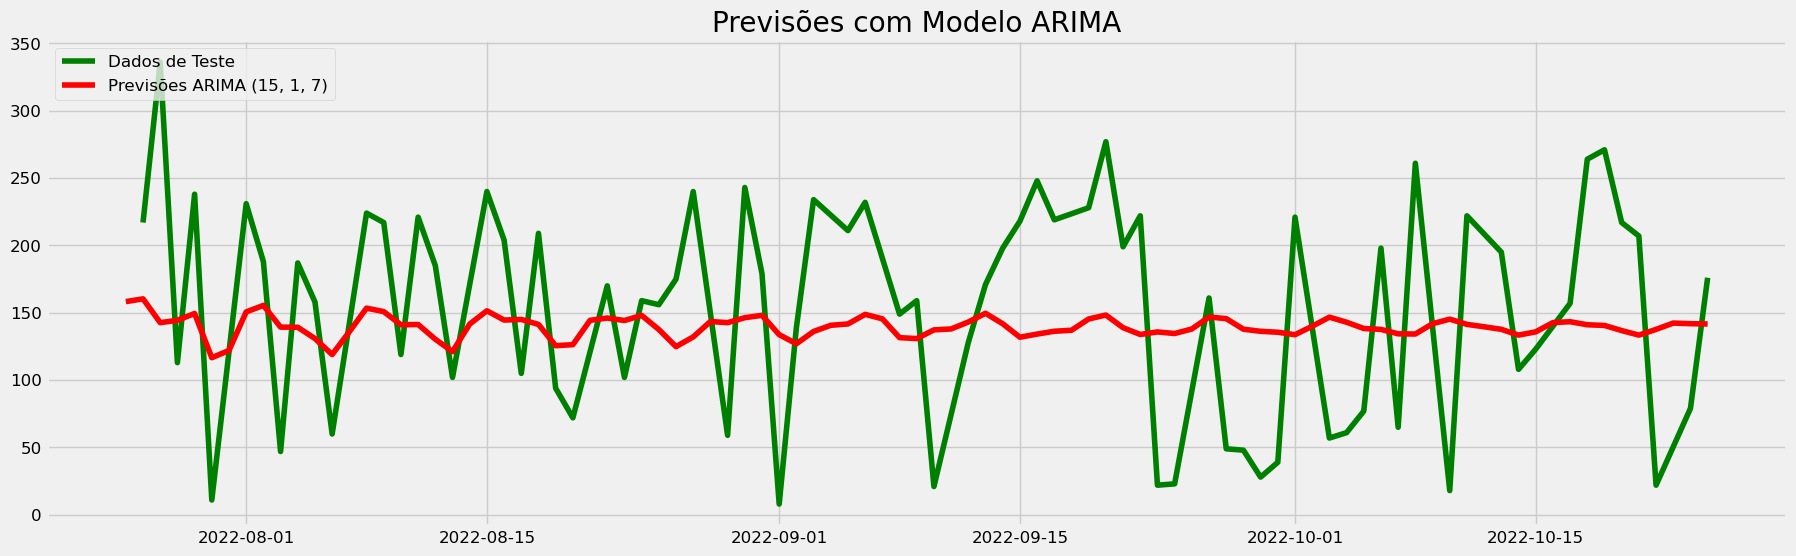

In [90]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (15, 1, 7)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [58]:
# Calculando a performance(1, 1, 0)
arima_results = performance(teste, arima_predict)

MSE das previsões é 5791.9283
RMSE das previsões é 76.1047
MAPE das previsões é 112.4405


In [68]:
# Calculando a performance (0, 1, 1)
arima_results = performance(teste, arima_predict)

MSE das previsões é 5825.3273
RMSE das previsões é 76.3238
MAPE das previsões é 111.1555


In [76]:
# Calculando a performance(15, 0, 7)
arima_results = performance(teste, arima_predict)

MSE das previsões é 6785.2785
RMSE das previsões é 82.3728
MAPE das previsões é 98.3249


In [91]:
# Calculando a performance(15, 1, 7)
arima_results = performance(teste, arima_predict)

MSE das previsões é 5623.149
RMSE das previsões é 74.9877
MAPE das previsões é 104.2562


Vamos executar alguns diagnósticos para avaliar o modelo.

Espera-se que os residos flutuem dentro da média 0 e mesma variância,
sejam estacionários, sem tendência e não sejam auto correlacionados

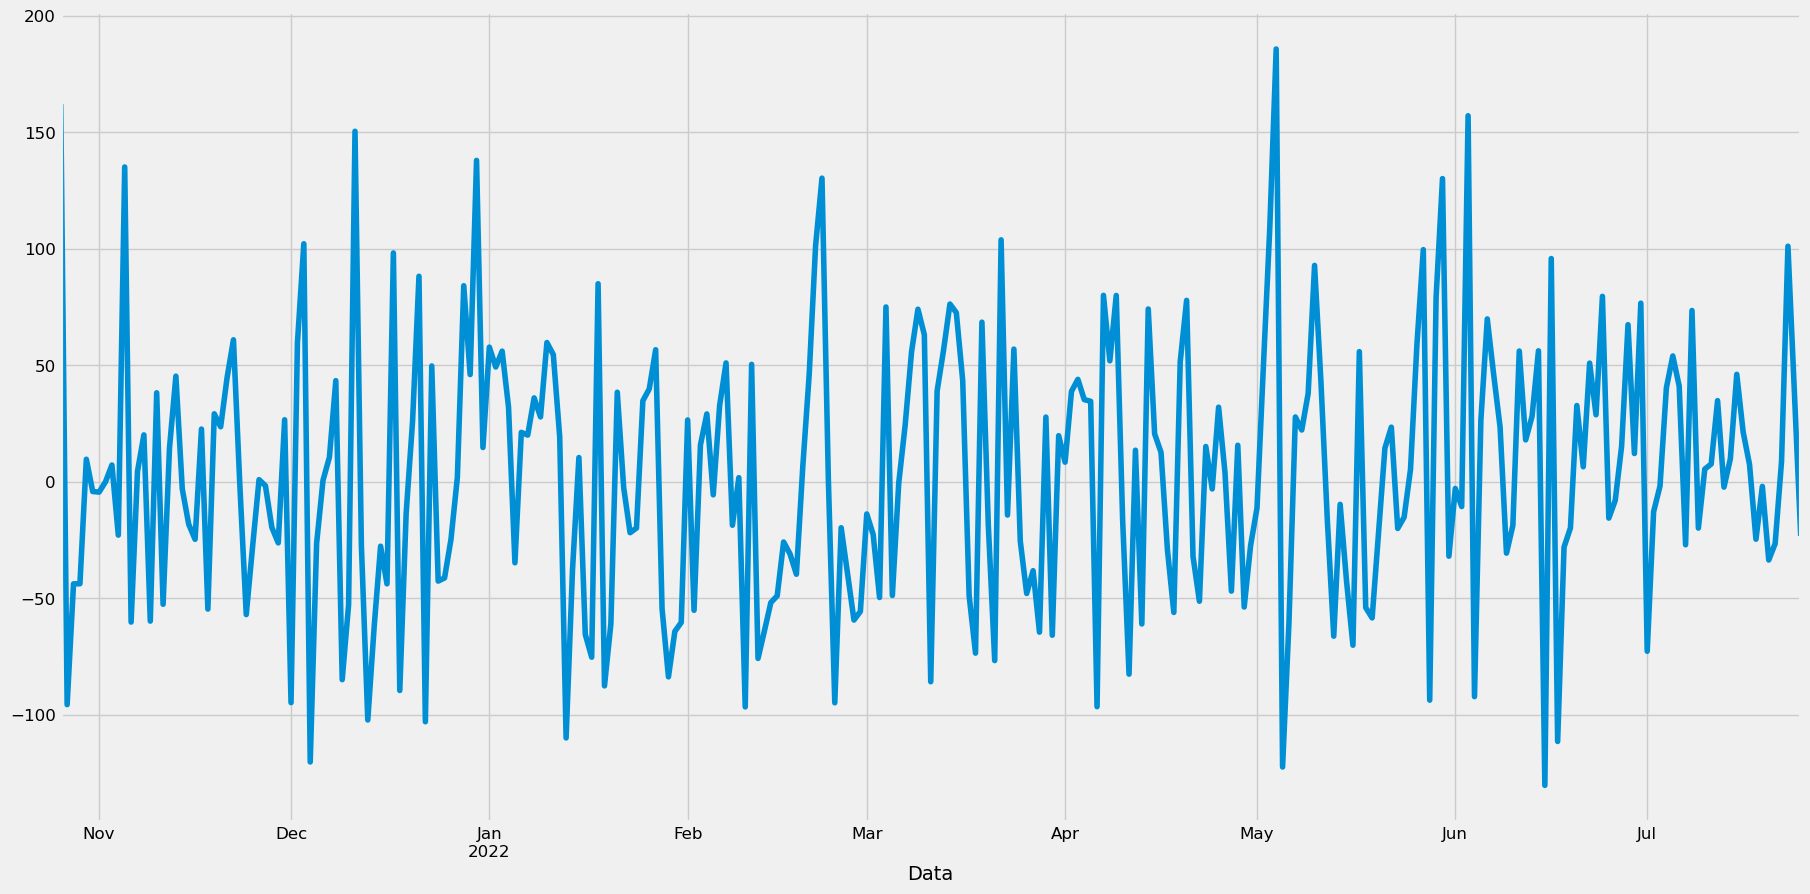

In [92]:
residuals = modelo_arima_fit.resid
residuals.plot()
plt.show()

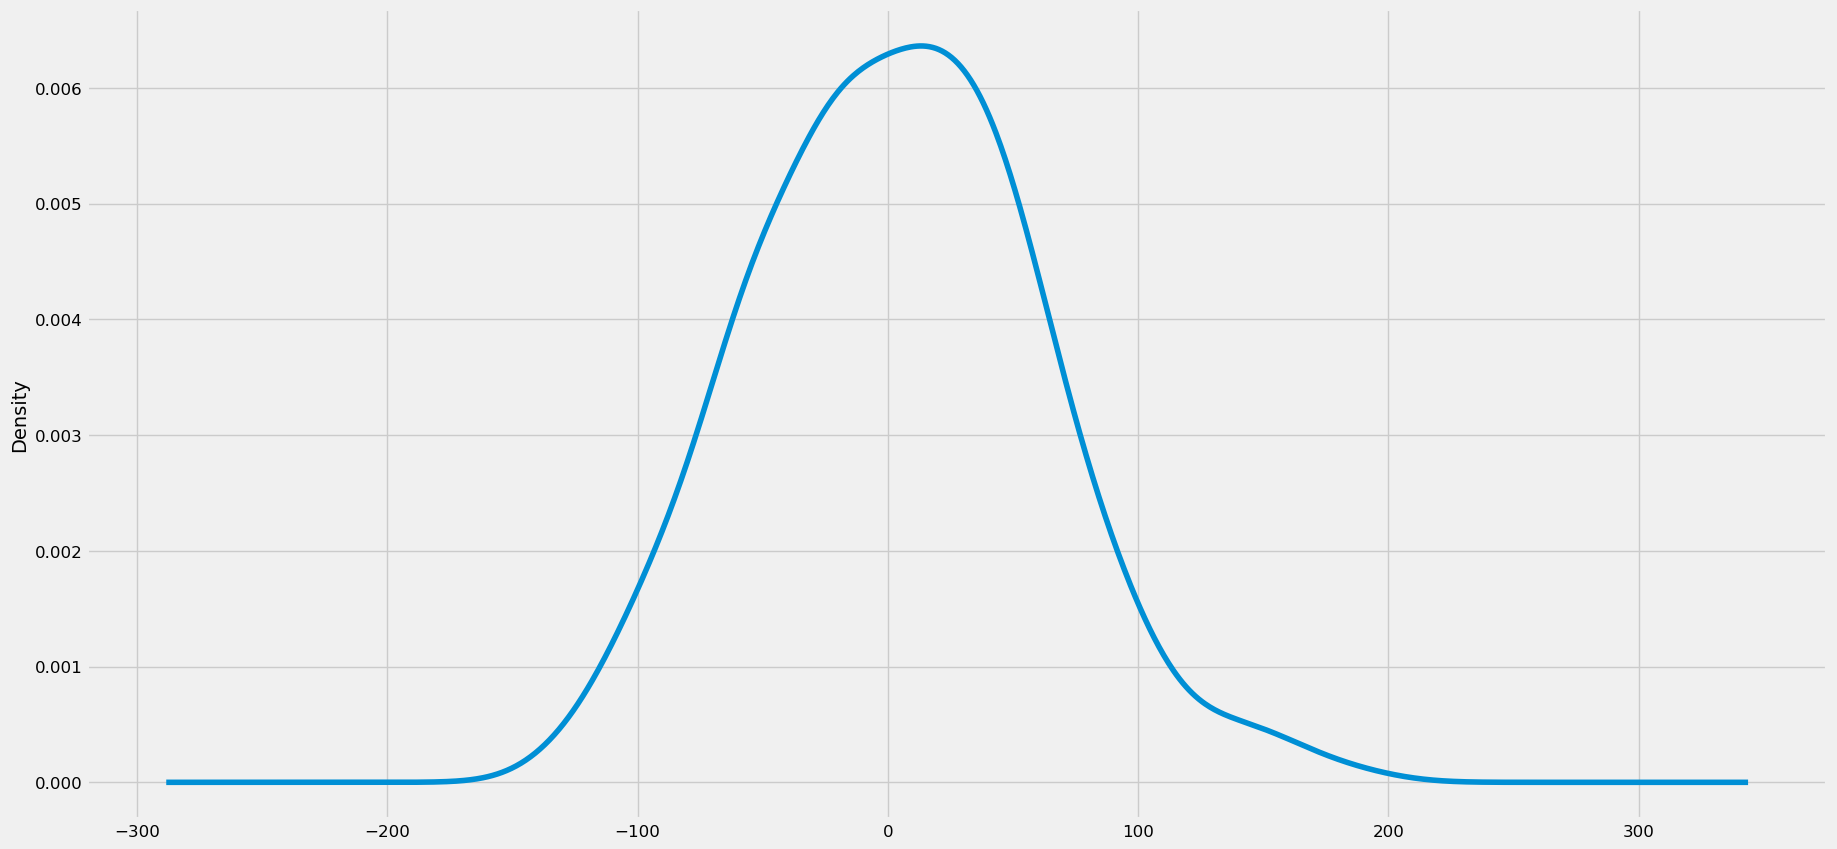

count    273.000000
mean       3.517452
std       57.226236
min     -130.309414
25%      -37.917130
50%        3.858214
75%       42.788811
max      185.697790
dtype: float64


In [93]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [94]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.32887168  -  Os resíduos parecem normalmente distribuídos.


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95% e, portanto,

um modelo ARIMA (15,1,7) fornece um bom ajuste do modelo.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula. 

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim